<a href="https://colab.research.google.com/github/zhiheng-qian/cs4875-research/blob/main/Simple_and_Scalable_Predictive_Uncertainty_Estimation_using_Deep_Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles. 

Balaji Lakshminarayanan Alexander Pritzel Charles Blundell

Paper source: https://arxiv.org/pdf/1612.01474v3.pdf

Summary: The idea of ensemble is motivated from MC-dropout in Bayesian neural network by Gal and Ghahramani[1]. It can compute predictive uncertainty estimation, which is computational efficient and scalable, yet performs better compared to Bayesian methods.

Problem: performance drops for adversarial training when the number of ensembles increases.

[1]: Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning https://arxiv.org/abs/1506.02142


Proper score rules:
1. $S(p_\theta , (y, \textbf{x} )) = log{p_\theta}(y|\textbf{x})$ when maximizing likelihood, as $S(p_\theta, q) = \mathbb{E}_{q(x)} q(y|\textbf{x}log{p_\theta}(y|\textbf{x})) \leq \mathbb{E}_{q(x)} q(y|\textbf{x}log{q}(y|\textbf{x}))$

2. In multi-class K-way classification, softmax cross entropy is equivalent to log likelihood.

3. Brier score: $\mathcal{L}(\theta) = -S(p\theta, (y,\textbf{x})) = K^{-1}\Sigma_{k=1}^K(\delta_{k=y} - p_\theta(y=k|\textbf{x}))^2$ (squared error between the predictive probability of a label and one-hot encoding of the correct label.)

For regression:
The common loss function such as MSE does not reflect on predictive uncertainty. A trick is to predict two values: predicted mean $\mu(x)$,  $variance$ :$\sigma^2 > 0$. Treating them as sample from Gaussian distribution, the loss function negative log-likelihood then is:

$-log{p_\theta}(y_n|\textbf{x}_n)  =   \frac{log{\sigma_\theta^2}(\textbf{x})}{2} + \frac{(y-\mu_\theta(\textbf{x}))^2}{2\sigma_\theta^2(\textbf{x})} + c$

Further investigation: 
1. Maximum likelihood estimation over $\mu_\theta (x)$ and $\sigma_\theta^2(x)$ might overfit; one could impose a prior and perform maximum-a-posteriori (MAP) estimation. 
2. In cases where the Gaussian is too-restrictive, one could use a complex distribution e.g. mixture density network or a heavy-tailed distribution.

Adversarial training: "use of adversarial training for predictive uncertainty estimation"

Ensemble: "We used the entire training dataset to train each network since deep NNs typically perform better with more data, although it is straightforward to use a random subsample if need be. We found that random initialization of the NN parameters, along with random shuffling of the data points, was sufficient to obtain good performance in practice."

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
m = nn.Softplus()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1>Regression on toy datasets<h1/>

$ y = x^3 + \epsilon$ where $\epsilon \backsim \mathcal{N}(0, 3^2)$

Baseline: Train single neural network to minimize MSE

1. Ensemble: Empirical variance of 5 networks trained using MSE
2. Baseline+NLL: Effect of training using NLL using a single net
3. Baseline+NLL+adversarial training: Additional effect of adversarial training
4. Ensemble+NLL+adversarial training: Effect of using an ensemble of 5 networks

<h2>Baseline<h2/>

In [3]:
np.random.seed(2)
x_train = np.random.uniform(-4, 4, 20)
y_train = np.power(x_train, 3) + np.random.normal(0, 3, 20)

xx = np.linspace(-6, 6, 100)
yy = np.power(xx, 3)

# fig, ax = plt.subplots(1)
# ax.plot(xx, yy, 'b')
# ax.plot(x_train, y_train, 'ro')

Based on the experiment setup by Herna ́ndez-Lobato and Adams, we use a single layer network with 100 hidden units. 

In [4]:
class SingleNet(nn.Module):
  def __init__(self):
    super(SingleNet, self).__init__()
    self.l1 = nn.Linear(1, 100)
    self.l2 = nn.Linear(100, 1)

  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    return x

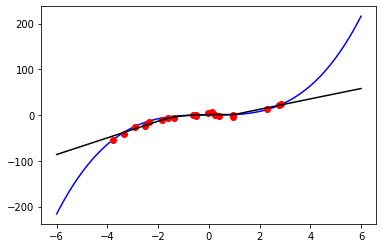

In [5]:
model = SingleNet()
learning_rate = 0.01
numEpochs = 40
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(numEpochs):
    for x, y in zip(x_train, y_train):
        x = torch.tensor([x], dtype = torch.float)
        y = torch.tensor([y], dtype = torch.float)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_func(y_pred, y)
        loss.backward()
        optimizer.step()
    #print('Loss at epoch {} is {}'.format(epoch, loss))

x_test = np.linspace(-6, 6, 100)
y_test = []
for x in x_test:
  x = torch.tensor([x], dtype = torch.float)
  y_test.append(model(x))
y_test = np.hstack(torch.stack(y_test).detach().numpy())

fig, ax = plt.subplots(1)
ax.plot(xx, yy, 'b')
ax.plot(x_train, y_train, 'ro')
ax.plot(x_test, y_test, 'k')

In [6]:
# fig.savefig('/content/drive/My Drive/AALTO/cs4875-research/img/baseline.png')

<h2>Ensemble<h2/>

An ensemble of 5 NNs to get multiple predictions and empirical variance of predictions as an approximate measure of uncertainty.

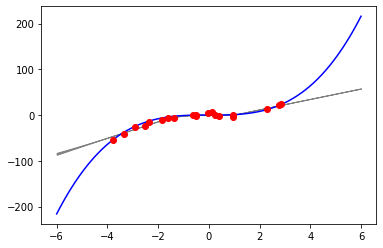

In [7]:
def ensemble(model, optimizer):
  for epoch in range(numEpochs):
      for x, y in zip(x_train, y_train):
          x = torch.tensor([x], dtype = torch.float)
          y = torch.tensor([y], dtype = torch.float)
          optimizer.zero_grad()
          y_pred = model(x)
          loss = loss_func(y_pred, y)
          loss.backward()
          optimizer.step()
      #print('Loss at epoch {} is {}'.format(epoch, loss))

  x_test = np.linspace(-6, 6, 100)
  y_test = []
  for x in x_test:
    x = torch.tensor([x], dtype = torch.float)
    y_test.append(model(x))
  y_test = np.hstack(torch.stack(y_test).detach().numpy())
  return y_test

y_tests = []
for i in range(5):
  model = SingleNet()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  y_tests.append(ensemble(model, optimizer))

y_tests = np.vstack(y_tests)
mu = np.mean(y_tests, 0)
var = np.var(y_tests, 0)


fig, ax = plt.subplots(1)
ax.plot(xx, yy, 'b')
ax.plot(x_train, y_train, 'ro')
# ax.plot(x_test, mu, 'k')
ax.fill_between(xx, mu+var, mu-var, color='grey')


In [8]:
# fig.savefig('/content/drive/My Drive/AALTO/cs4875-research/img/ensemble.png')

<h2>Baseline+NLL<h2/>

We use the probabilistic model from the paper which outputs two value in the final layer, predicted mean $\mu(x)$ and variance respectively.

In [9]:
def nll_loss(mu, var, y_train):
  return 0.5*torch.log(var) + 0.5*(y_train - mu)**2/var

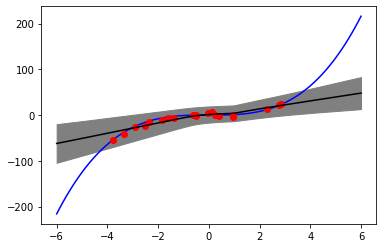

In [13]:
class SingleNetNll(nn.Module):
  def __init__(self):
    super(SingleNetNll, self).__init__()
    self.l1 = nn.Linear(1, 100)
    self.l2 = nn.Linear(100, 2)

  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    return x

class SingleProbNetNll(nn.Module):
  def __init__(self):
    super(SingleProbNetNll, self).__init__()
    self.l1 = nn.Linear(1, 100)
    # self.l2 = nn.Linear(100, 100)
    self.mean_head = nn.Linear(100, 1)
    self.var_head = nn.Linear(100, 1)

  def forward(self, x):
    x = F.relu(self.l1(x))
    # x = F.relu(self.l2(x))
    mean_x = self.mean_head(x)
    var_x = F.elu(self.var_head(x)) + 1.0
    return mean_x, var_x

model = SingleProbNetNll()
learning_rate = 0.01
numEpochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(numEpochs):
    for x, y in zip(x_train, y_train):
        x = torch.tensor([x], dtype = torch.float)
        y = torch.tensor([y], dtype = torch.float)
        optimizer.zero_grad()
        output = model(x)
        loss = nll_loss(output[0], m(output[1])+ 1e-06, y)
        loss.backward()
        optimizer.step()
    #print('Loss at epoch {} is {}'.format(epoch, loss))

x_test = np.linspace(-6, 6, 100)
mu_test = []
var_test = []
for x in x_test:
  x = torch.tensor([x], dtype = torch.float)
  mu_test.append(model(x)[0])
  var_test.append(model(x)[1])

mu_test = np.hstack(torch.stack(mu_test).detach().numpy())
var_test = np.hstack(torch.stack(var_test).detach().numpy())

fig, ax = plt.subplots(1)
ax.plot(xx, yy, 'b')
ax.plot(x_train, y_train, 'ro')
ax.plot(x_test, mu_test, 'k')
ax.fill_between(xx, mu_test+var_test, mu_test-var_test, color='grey')

In [14]:
# fig.savefig('/content/drive/My Drive/AALTO/cs4875-research/img/baseline+nll.png')

<h2>Baseline+NLL+adversarial training<h2/>

Adversarial sample $\textbf{x}' = \textbf{x} + \epsilon sign(\nabla_{\textbf{x}} \ell(\theta, \textbf{x}, y)) $

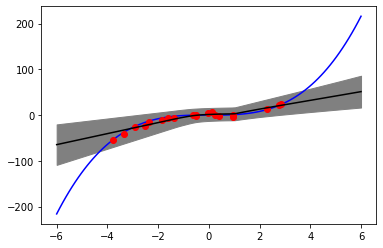

In [15]:
model = SingleProbNetNll()
learning_rate = 0.01
numEpochs = 40
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(numEpochs):
    for x, y in zip(x_train, y_train):
        x = torch.tensor([x], dtype = torch.float, requires_grad=True)
        y = torch.tensor([y], dtype = torch.float)
        optimizer.zero_grad()
        output = model(x)
        loss = nll_loss(output[0], m(output[1])+ 1e-06, y)
        loss.backward(retain_graph=True)

        x_prime = x + 0.04*(torch.sign(x.grad))
        optimizer.zero_grad()
        output_prime = model(x_prime)
        loss = nll_loss(output[0], m(output[1])+ 1e-06, y) + nll_loss(output_prime[0], m(output_prime[1])+ 1e-06, y)
        loss.backward()

        optimizer.step()
    #print('Loss at epoch {} is {}'.format(epoch, loss))

x_test = np.linspace(-6, 6, 100)
mu_test = []
var_test = []
for x in x_test:
  x = torch.tensor([x], dtype = torch.float)
  mu_test.append(model(x)[0])
  var_test.append(model(x)[1])

mu_test = np.hstack(torch.stack(mu_test).detach().numpy())
var_test = np.hstack(torch.stack(var_test).detach().numpy())

fig, ax = plt.subplots(1)
ax.plot(xx, yy, 'b')
ax.plot(x_train, y_train, 'ro')
ax.plot(x_test, mu_test, 'k')
ax.fill_between(xx, mu_test+var_test, mu_test-var_test, color='grey')

In [16]:
# fig.savefig('/content/drive/My Drive/AALTO/cs4875-research/img/baseline+nll+adv.png')

<h2>Ensemble+NLL+adversarial training<h2/>

$\mu_*(\textbf{x}) = M^{-1} \Sigma_{m} \mu_{\theta_m}(\textbf{x}) $

$\sigma_*^2 (\textbf{x}) = M^{-1}\Sigma_m (\sigma^2_{\theta_m} (\textbf{x}) + \mu^2_{\theta_m}(\textbf{x})) - \mu^2_*(\textbf{x})$

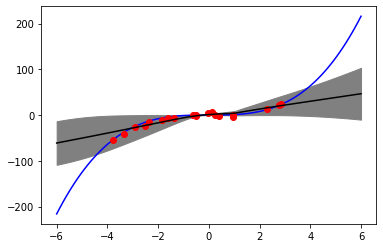

In [17]:
def ensembleWithAdversarial(model, optimizer):
  for epoch in range(numEpochs):
      for x, y in zip(x_train, y_train):
          x = torch.tensor([x], dtype = torch.float, requires_grad=True)
          y = torch.tensor([y], dtype = torch.float)
          optimizer.zero_grad()
          output = model(x)
          loss = nll_loss(output[0], m(output[1])+ 1e-06, y)
          loss.backward(retain_graph=True)

          x_prime = x + 0.04*(torch.sign(x.grad.data.sign()))
          optimizer.zero_grad()
          output_prime = model(x_prime)
          loss = nll_loss(output[0], m(output[1])+ 1e-06, y) + nll_loss(output_prime[0], m(output_prime[1])+ 1e-06, y)
          loss.backward()

          optimizer.step()

  x_test = np.linspace(-6, 6, 100)
  mu_test = []
  var_test = []
  for x in x_test:
    x = torch.tensor([x], dtype = torch.float)
    mu_test.append(model(x)[0])
    var_test.append(model(x)[0])
  mu_test = np.hstack(torch.stack(mu_test).detach().numpy())
  var_test = np.hstack(torch.stack(var_test).detach().numpy())
  return mu_test, var_test

mu_tests = []
var_tests = []
for i in range(5):
  model = SingleProbNetNll()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  mu_test, var_test = ensembleWithAdversarial(model, optimizer)
  mu_tests.append(mu_test)
  var_tests.append(var_test)

mu_tests = np.vstack(mu_tests)
var_tests = np.vstack(var_tests)

mu_optimal = np.mean(mu_tests, 0)
var_optimal = np.mean(mu_tests*mu_tests + var_tests, 0) - mu_optimal*mu_optimal

fig, ax = plt.subplots(1)
ax.plot(xx, yy, 'b')
ax.plot(x_train, y_train, 'ro')
ax.plot(x_test, mu_optimal, 'k')
ax.fill_between(xx, mu_optimal+var_optimal, mu_optimal-var_optimal, color='grey')


In [ ]:
# fig.savefig('/content/drive/My Drive/AALTO/cs4875-research/img/ensemble+nll+adv.png')

<h2>Regression on <h2/>

In [ ]:
batch_size = 100
#optimizer = adam
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
learning_rate = 0.01
#adv_epsilon = 0.01 * range of train set along the particular dimension

Reference:
1. Paper review & code: Deep Ensembles (NIPS 2017). Alberto Arrigoni. https://medium.com/@albertoarrigoni/paper-review-code-deep-ensembles-nips-2017-c5859070b8ce
2. Deep ensemble. Github: cameronccohen. https://github.com/cameronccohen/deep-ensembles/blob/master/Tutorial.ipynb
3. 68–95–99.7 rule. Wiki. https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule